# A/B тесты

Компания по доставке пиццы, работа над приложением для курьеров.
Есть проблема: к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены доставка очень сильно проседает в эффективности. 

Data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 

Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

Сначала формулируем основные гипотезы:

$Н_0$ - Разницы между средним временем доставки в тестовой и контрольной группе нет

$Н_1$ - Разница между средним временем доставки в тестовой и контрольной группе есть

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import pandas.util.testing as tm

In [2]:
delivery = pd.read_csv('https://stepik.org/media/attachments/lesson/385916/experiment_lesson_4.csv')
delivery.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


In [3]:
#проверяем типы данных
delivery.dtypes

order_id              int64
delivery_time       float64
district             object
experiment_group     object
dtype: object

Смотрим на графики распределения контрольной и тестовой групп

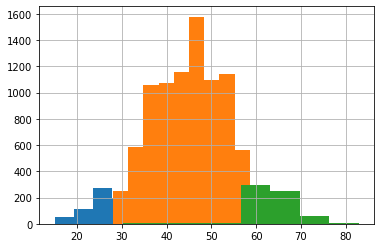

In [5]:
delivery.query('experiment_group == "control"') \
        .groupby('district') \
        .delivery_time \
        .hist();

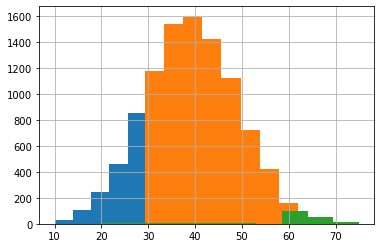

In [7]:
delivery.query('experiment_group == "test"') \
        .groupby('district') \
        .delivery_time \
        .hist();

In [8]:
#смотрим на количество наблюдений в обеих группах
delivery.groupby('experiment_group').agg({'order_id' : 'count'})

,order_id
experiment_group,
control,10092
test,10104


In [26]:
test = delivery.query('experiment_group == "test"').delivery_time
control = delivery.query('experiment_group == "control"').delivery_time

Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.

In [16]:
stats.shapiro(control.sample(1000))

(0.9954919219017029, 0.0048313504084944725)

In [11]:
stats.shapiro(test.sample(1000))

(0.9973248839378357, 0.09760621935129166)

Видим, что pvalue > 0.05, значит мы не отклоняем нулевую гипотезу о нормальности распределения

In [17]:
#стандартное отклонение в контрольной группе
np.std(control)

9.882819260031312

In [18]:
#стандартное отклонение в тестовой группе
np.std(test)

9.989522000653128

Теперь сравниваем средние в тесте и контроле (с помощью t-test Стьюдента)

In [20]:
stats.ttest_ind(control, test)

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

In [24]:
test.mean(), control.mean()

(45.065101070154576, 39.04681314330958)

In [27]:
(test.mean() - control.mean()) * 100 / control.mean()

-13.354653121660812

Вывод:
    В результате проведения А/B теста мы подтвердили, что новый алгоритм статистически значимо уменьшил среднее время доставки (следовательно, имеет смысл вводить данное обновление). Среднее время доставки уменьшилось на 13%.

***
## Задача 2
Посмотрим, что известно и что требуется:

В контрольной группе (а) 1928 платящих из 202103. В тестовой группе (b) 1805 платящих из 202667. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [28]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/409318/problem2.csv', sep=';')
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


Проверим, статичтически значимо или нет преимущество ARPU тестовой группы над ARPU контрольной группы.

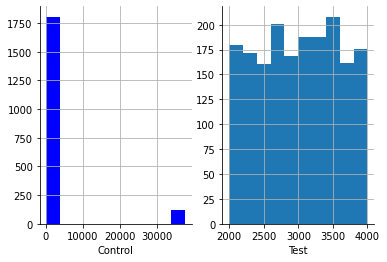

In [31]:
plt.subplot(1, 2, 1)
df.query('testgroup == "a" and revenue > 0')['revenue'].hist(color='blue')
plt.xlabel('Control')

plt.subplot(1, 2, 2)
df.query('testgroup == "b" and revenue > 0')['revenue'].hist()
plt.xlabel('Test')

sns.despine()

Выбросы в контрольной группе. В любом случае, исключить мы их не можем, потому что не знаем природы возникновения. Значит для оценки нужен критерий, устойчивый к выбросам: обратимся к U-критерию Манна-Уитни.

In [32]:
#  Проведём тест и посмотрим на p-уровень значимости.
statistic, pvalue = stats.mannwhitneyu(df.query('testgroup == "a"').revenue,
                                       df.query('testgroup == "b"').revenue)
print('pvalue =', pvalue.round(2))

pvalue = 0.03


In [38]:
#  Посчитаем ARPU для контрольной и тестовой групп.
ARPU_control = df.query('testgroup == "a"').revenue.mean()
ARPU_test = df.query('testgroup == "b"').revenue.mean()

print(f'ARPU_control = {ARPU_control}')
print(f'ARPU_control = {ARPU_test}')
print(f'ARPU_test > ARPU_control на {round((ARPU_test - ARPU_control) / ARPU_test * 100, 2)}%')

ARPU_control = 25.413719736965806
ARPU_control = 26.75128659327863
ARPU_test > ARPU_control на 5.0%


Итак, с помощью U-критерия Манна-Уитни удалось определить: ARPU тестовой группы статистически значимо выше, чем ARPU контрольной группы на 5.01%. Но pvalue = 0.03... Это конечно хорошо, если α = 0.05. Но нам очень не хочется совершить ошибку первого рода, приняв альтернативную гипотезу, и отклонив при этом верную - нулевую. Поэтому, если мы примем α = 0.01 для большей уверенности, то поводов для отклонения нулевой гипотезы уже не будет.

Чтобы подстраховаться, обратимся к "универсальному инструменту", результаты которого потенциально более точны: Bootstrap.

In [39]:
sample_a = df.query('testgroup == "a"').revenue
sample_b = df.query('testgroup == "b"').revenue

samples = pd.DataFrame({
    "sample_a": sample_a,
    "sample_b": sample_b
}).fillna(0)

samples

,sample_a,sample_b
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
404765,0.0,0.0
404766,0.0,0.0
404767,231.0,0.0
404768,0.0,0.0


In [44]:
from tqdm.auto import tqdm
#  Помним о выбросах, поэтому используем в качестве меры центральной тенденции медиану.

def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it = 1000,
    statistic = np.median,
    bootstrap_conf_level = 0.99    # зададим уровень в соответствии с нашей новой α = 0.01.
):
      
    """
        data_column_1, # числовые значения первой выборки
        data_column_2, # числовые значения второй выборки
        boot_it = 1000, # количество бутстрэп-подвыборок
        statistic = np.median, # интересующая нас статистика 
    """
    
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

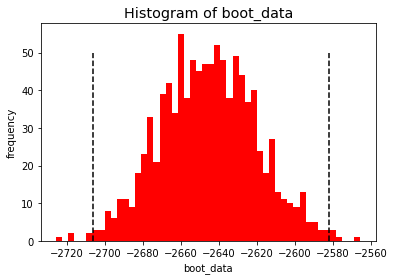

In [45]:
booted_data_median = get_bootstrap(samples.query('sample_a != 0').sample_a,
                                   samples.query('sample_b != 0').sample_b)


In [48]:
booted_data_median['quants']

,0
0.005,-2706.0100
0.995,-2581.9975


In [49]:
booted_data_median['p_value']

0.0

Видим, что доверительный интервал вышел за 0, а p_value = 0.0.

Вот так уже лучше, теперь с определённой уверенностью мы можем сказать, что в тестовой группе статистически значимо увеличился ARPU по отношению к контрольной группе.

Но мы также не могли не заметить, что в тестовой группе, которая сама по себе немного больше, чем контрольная, платящих пользователей стало меньше, чем в контрольной. Нужно проверить, имеет ли такое снижение платящих пользователей статистическую значимость.

In [50]:
# Воспользуемся А/В тестом для пропорций.
# В контрольной группе (а) 1928 платящих из 202103.
# В тестовой группе (b) 1805 платящих из 202667.

s1, s2 = 1928, 1805
n1, n2 = 202103, 202667

In [56]:
import statsmodels.api as sm
z, p_value = sm.stats.proportions_ztest([s1, s2], [n1, n2])
print('p_value =', p_value)

p_value = 0.035028524642854865


И что мы видим: p_value < 0.05. Значит количество платящих пользователей статистически значимо уменьшилось(по крайней мере если опираться на α = 0.05). Это для нас нехорошо.

Но мы помним про выбросы. А что если если был сбой системы, и все наши "VIP-плательщики" на самом деле не заплатили ничего. Тогда тест покажет другой результат.

In [60]:
z, p_value = sm.stats.proportions_ztest([s2, s2], [n1, n2])
print('p_value =', p_value)

p_value = 0.9329809027702953


Всё упирается в выбросы.

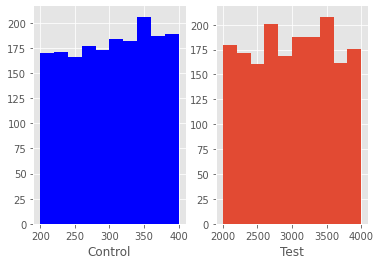

In [62]:
#  Построим распределения платящих пользователей для контрольной и тестовой групп, но теперь без учёта выбросов.
plt.subplot(1, 2, 1)
df.query('testgroup == "a" and 0 < revenue < 5000')['revenue'].hist(color='blue')
plt.xlabel('Control')

plt.subplot(1, 2, 2)
df.query('testgroup == "b" and revenue > 0')['revenue'].hist()
plt.xlabel('Test')

sns.despine()

По графикам видно, что, если не принимать во внимание выбросы в контрольной группе, то размах Revenue в контрольной группе 200 - 400, а в тестовой 2000 - 4000. Разница очевидна. Посчитаем точно.

In [63]:
#  ARPPU контрольной группы без выбросов и ARPPU тестовой группы.
ARPPU_control = df.query('testgroup == "a" and 0 < revenue < 30000').revenue.mean()
ARPPU_test = df.query('testgroup == "b" and revenue > 0').revenue.mean()

print('ARPPU_control =', ARPPU_control)
print('ARPPU_test =', ARPPU_test)
#  Тут видим десятикратное превосходство ARPPU тестовой группы

ARPPU_control = 302.45817174515236
ARPPU_test = 3003.6581717451522


In [64]:
#  Посмотрим на характеристики наших "VIP-пользователей"
df.query('testgroup == "a" and revenue > 5000').revenue.describe()
#  Всего 123 пользователя и подозрительно маленькое стандартное отклонение.

count      123.000000
mean     37319.121951
std         25.442183
min      37293.000000
25%      37301.000000
50%      37311.000000
75%      37329.000000
max      37433.000000
Name: revenue, dtype: float64

## Выводы:

 1. Проанализировав данные, мы установили, что ARPU в тестовой группе статистически значимо увеличилось на 5% по сравнению с контрольной группой.

 2. Также мы увидели выбросы в контрольной группе, которые говорят либо о наличии в ней группы пользователей, которым настолько нравится наше приложение в том виде, в котором оно есть, что они всё покупают и покупают 
самые дорогие саженцы и лейки 99 уровня, каждая из которых может полить за один раз до 1Га их любимого сада:) (это, конечно, маловероятно - выбросы слишком уж велики и мало отличаются между собой), либо это баг.

 3. В любом случае: если выбросы — реальные пользователи; баг программы, записавший в "VIP-пользователи" тех, кто на самом деле ничего не заплатил), то мы принимаем изменения с одной лишь разницей: если "VIP-пользователи"
реальны, то на них изменения пока не раскатываем (по ним лучше отдельно провести свой А/В-тест и посмотреть, нравится им или нет), если же баг, и вместо больших сумм - нули, то просто раскатываем на всех.